In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from torch import nn
import torchvision
from torchinfo import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


import seaborn as sns
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading Data 

In [3]:
class CustomDataset(Dataset):
    def __init__(self, transform, root_dir, split = 'Training'):
        self.root_dir = os.path.join(root_dir, split) #Get root directory
        self.categories = os.listdir(self.root_dir) #Get all different labels
        self.transform = transform #Get the transformation provided
        self.split = split #Is the data a training or testing split?
        self.label_dict = {} #Dictionary with keys as indices, values as the categories of brain MRIs
        self.data = self.load_data()
        
    def load_data(self):
        data = [] #Initialize empty list to hold image paths
        for i, category in enumerate(self.categories): #Create tuples of (index, category) to iterate over
            
            category_path = os.path.join(self.root_dir, category) #Get path to brain MRI category
            self.label_dict[i] = category #ith key corresponds to ith value
            
            for file_name in os.listdir(category_path): #os.listdir(category_path) is a list of file names in category_path
                img_path = os.path.join(category_path, file_name) #get paths for individual images
                
                data.append([img_path, i]) #data is a list of lists
                                           #Each list has image path in 0th index, label in 1st index
        return data
    
    def __len__(self):
        return len(self.data) #Return length of data
    
    def __getitem__(self , idx):
        img_path, label = self.data[idx] #0th entry is image path, 1st entry is label 
        image = Image.open(img_path).convert("L") #Open image, convert to greyscale
        label = torch.tensor(label) #Make image label into PyTorch tensor
        if self.transform:
            transformed_image = self.transform(image) #Transform image if transform is provided
            
        return transformed_image.to(device), label.to(device)

In [4]:
#Defining transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), #Resize image to 224 x 224
    transforms.ColorJitter(brightness=(0.8,1.2),
                            contrast=(0.8,1.2),
                            saturation=(0.8,1.2),
                            hue=0.25),
    transforms.RandomAffine(5, translate=(0.01,0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]) #ImageNet mean and std
])

In [5]:
root = "/kaggle/input/brain-tumor-mri-dataset"

In [6]:
train_dataset = CustomDataset(train_transform, root_dir = root, split = 'Training')
test_dataset = CustomDataset(test_transform, root_dir = root, split = 'Testing')

In [7]:
#Checking class proportions
category_sizes = []

for category in train_dataset.categories:
    category_path = os.path.join(train_dataset.root_dir, category)
    category_size = len(os.listdir(category_path))
    category_sizes += [category_size]
    print(f'Number of MRIs in {category}: {category_size}')
    
total_mri = sum(category_sizes)

for category in train_dataset.categories:
    category_path = os.path.join(train_dataset.root_dir, category)
    category_size = len(os.listdir(category_path))
    print(f'Proportion of MRIs in {category}: {category_size/total_mri}')

Number of MRIs in pituitary: 1457
Number of MRIs in notumor: 1595
Number of MRIs in meningioma: 1339
Number of MRIs in glioma: 1321
Proportion of MRIs in pituitary: 0.2550770308123249
Proportion of MRIs in notumor: 0.27923669467787116
Proportion of MRIs in meningioma: 0.2344187675070028
Proportion of MRIs in glioma: 0.23126750700280113


The training data is quite balanced: we will not use class weights or other methods for class imbalances.

In [8]:
#Dictionary of labels
label_dict = train_dataset.label_dict

In [9]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

## Visualizing Images 

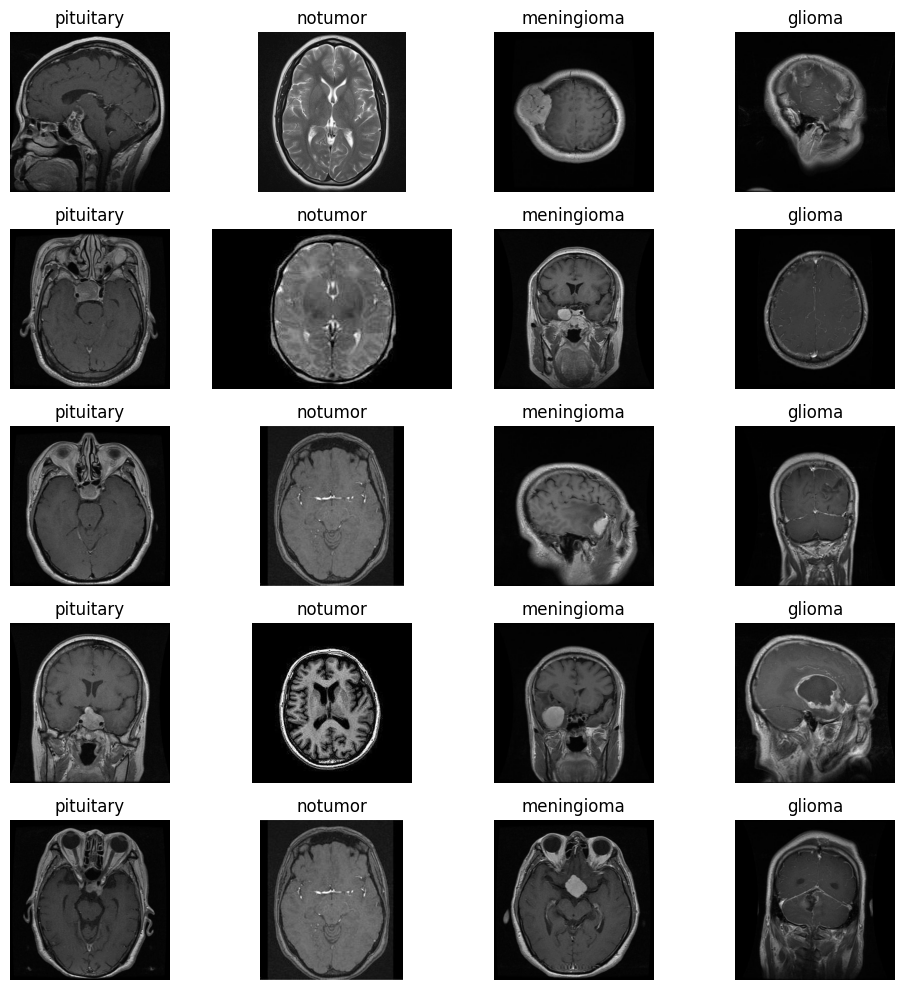

In [10]:
fig, axes = plt.subplots(5, 4, figsize = (10,10))
categories = os.listdir('/kaggle/input/brain-tumor-mri-dataset/Training')
for i in range(len(categories)): 
    for j in range(5):
        category_path = os.path.join('/kaggle/input/brain-tumor-mri-dataset/Training', categories[i])
        category_images = random.sample(os.listdir(category_path), 1)[0]
        random_image = os.path.join(category_path , category_images )
        axes[j, i].imshow(Image.open(random_image).convert("L"), cmap = 'gray')
        axes[j, i].set_title(categories[i])
        axes[j, i].set_axis_off()
        
plt.tight_layout()

Some images contain information on the edges, so we should probably use padding in the training process.

#  Model Building

In [11]:
#Function for convolution block in CNN
def convBlock(input_sz, output_sz):
    return nn.Sequential(
        nn.Conv2d(input_sz, output_sz, kernel_size = 3, padding = 1), #Padding of 1
        nn.ReLU(),
        nn.BatchNorm2d(output_sz),
        nn.MaxPool2d(2)
    )

In [12]:
class BrainCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.model = nn.Sequential(
        convBlock(1, 32),
        convBlock(32, 32),
        convBlock(32, 64),
        convBlock(64, 128),
        nn.Flatten(),
        nn.Linear(25088, 128),
        nn.Linear(128, num_classes))
        
    def forward(self, x):
        return self.model(x)

In [13]:
brainCNN = BrainCNN(num_classes = 4).to(device)

In [14]:
def print_num_parameters(model, name="model"):
    print("Number of parameters in %s" % name,
          sum(p.numel() for p in model.parameters()))

print_num_parameters(brainCNN, name = "BrainCNN")

Number of parameters in BrainCNN 3314340


In [15]:
optimizer = torch.optim.Adam(brainCNN.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

# Training Loop 

In [21]:
#Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 20

for epoch in range(epochs):
    brainCNN.train()
    train_loss = 0.0
    correct = 0
    total = 0
    correct = 0 #Set to 0 on every iteration
    total = 0 #Set to 0 on every iteration

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1} Training'):
        optimizer.zero_grad() #Clear gradients during the start of every iteration
        outputs = brainCNN(inputs) #Run inputs through the network
        loss = criterion(outputs, labels) #Get loss from model outputs
        loss.backward() #Backprop
        optimizer.step() #Gradient step, this is updating parameters

        train_loss += loss.item() #Update training loss, .item() gets number from tensor object
        _, predicted = torch.max(outputs, 1) #Predicted class is the Bayes optimal one (highest posterior probability)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct/total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    #Evaluating validation loss
    brainCNN.eval()
    val_loss = 0.0 #Set to 0 on every iteration
    correct = 0 #Set to 0 on every iteration
    total = 0 #Set to 0 on every iteration

    with torch.no_grad(): #Clear gradients to evaluate using the trained weights
        for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1} Validation'):
            outputs = brainCNN(inputs) #Run inputs through the network
            loss = criterion(outputs, labels) #Compute validation loss

            val_loss += loss.item() #Update validation loss
            _, predicted = torch.max(outputs , 1) #Predicted class is the Bayes optimal one (highest posterior probability)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Calculating validation accuracy...')
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')

Epoch 1 Validation: 100%|██████████| 21/21 [00:04<00:00,  5.25it/s]


Calculating validation accuracy...
Epoch [1/20], Training Loss: 66.5921, Training Accuracy: 73.97%, Validation Loss: 14.2988, Validation Accuracy: 73.15%


Epoch 2 Validation: 100%|██████████| 21/21 [00:04<00:00,  5.22it/s]


Calculating validation accuracy...
Epoch [2/20], Training Loss: 57.6234, Training Accuracy: 75.47%, Validation Loss: 10.7546, Validation Accuracy: 79.33%


Epoch 3 Validation: 100%|██████████| 21/21 [00:04<00:00,  5.19it/s]


Calculating validation accuracy...
Epoch [3/20], Training Loss: 48.7494, Training Accuracy: 79.50%, Validation Loss: 10.2122, Validation Accuracy: 80.70%


Epoch 4 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.83it/s]


Calculating validation accuracy...
Epoch [4/20], Training Loss: 46.2785, Training Accuracy: 81.20%, Validation Loss: 10.2673, Validation Accuracy: 80.55%


Epoch 5 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


Calculating validation accuracy...
Epoch [5/20], Training Loss: 41.6628, Training Accuracy: 83.21%, Validation Loss: 12.3405, Validation Accuracy: 79.79%


Epoch 6 Validation: 100%|██████████| 21/21 [00:04<00:00,  5.02it/s]


Calculating validation accuracy...
Epoch [6/20], Training Loss: 40.3602, Training Accuracy: 84.10%, Validation Loss: 10.1989, Validation Accuracy: 82.91%


Epoch 7 Validation: 100%|██████████| 21/21 [00:04<00:00,  5.16it/s]


Calculating validation accuracy...
Epoch [7/20], Training Loss: 38.4498, Training Accuracy: 85.15%, Validation Loss: 11.0283, Validation Accuracy: 80.24%


Epoch 8 Validation: 100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Calculating validation accuracy...
Epoch [8/20], Training Loss: 38.3874, Training Accuracy: 84.61%, Validation Loss: 10.3981, Validation Accuracy: 83.07%


Epoch 9 Validation: 100%|██████████| 21/21 [00:03<00:00,  5.27it/s]


Calculating validation accuracy...
Epoch [9/20], Training Loss: 33.5678, Training Accuracy: 86.54%, Validation Loss: 7.8591, Validation Accuracy: 86.04%


Epoch 10 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


Calculating validation accuracy...
Epoch [10/20], Training Loss: 31.4035, Training Accuracy: 87.59%, Validation Loss: 8.3008, Validation Accuracy: 84.59%


Epoch 11 Validation: 100%|██████████| 21/21 [00:04<00:00,  5.19it/s]


Calculating validation accuracy...
Epoch [11/20], Training Loss: 33.1391, Training Accuracy: 87.27%, Validation Loss: 8.0460, Validation Accuracy: 85.96%


Epoch 12 Validation: 100%|██████████| 21/21 [00:04<00:00,  5.18it/s]


Calculating validation accuracy...
Epoch [12/20], Training Loss: 30.8871, Training Accuracy: 88.11%, Validation Loss: 12.0370, Validation Accuracy: 80.93%


Epoch 13 Validation: 100%|██████████| 21/21 [00:04<00:00,  5.01it/s]


Calculating validation accuracy...
Epoch [13/20], Training Loss: 24.8415, Training Accuracy: 90.07%, Validation Loss: 5.7238, Validation Accuracy: 90.39%


Epoch 14 Validation: 100%|██████████| 21/21 [00:03<00:00,  5.29it/s]


Calculating validation accuracy...
Epoch [14/20], Training Loss: 25.5845, Training Accuracy: 89.48%, Validation Loss: 5.3122, Validation Accuracy: 91.08%


Epoch 15 Validation: 100%|██████████| 21/21 [00:04<00:00,  5.04it/s]


Calculating validation accuracy...
Epoch [15/20], Training Loss: 27.2630, Training Accuracy: 89.72%, Validation Loss: 9.8312, Validation Accuracy: 84.82%


Epoch 16 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.97it/s]


Calculating validation accuracy...
Epoch [16/20], Training Loss: 23.1992, Training Accuracy: 90.90%, Validation Loss: 28.2436, Validation Accuracy: 63.69%


Epoch 17 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.87it/s]


Calculating validation accuracy...
Epoch [17/20], Training Loss: 24.6855, Training Accuracy: 89.95%, Validation Loss: 4.9625, Validation Accuracy: 91.84%


Epoch 18 Validation: 100%|██████████| 21/21 [00:04<00:00,  5.21it/s]


Calculating validation accuracy...
Epoch [18/20], Training Loss: 21.7949, Training Accuracy: 91.42%, Validation Loss: 6.7083, Validation Accuracy: 88.71%


Epoch 19 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.96it/s]


Calculating validation accuracy...
Epoch [19/20], Training Loss: 21.5536, Training Accuracy: 91.60%, Validation Loss: 13.3382, Validation Accuracy: 78.11%


Epoch 20 Validation: 100%|██████████| 21/21 [00:04<00:00,  5.09it/s]

Calculating validation accuracy...
Epoch [20/20], Training Loss: 19.2580, Training Accuracy: 92.31%, Validation Loss: 6.3729, Validation Accuracy: 88.79%


## Training and Validation Metrics 

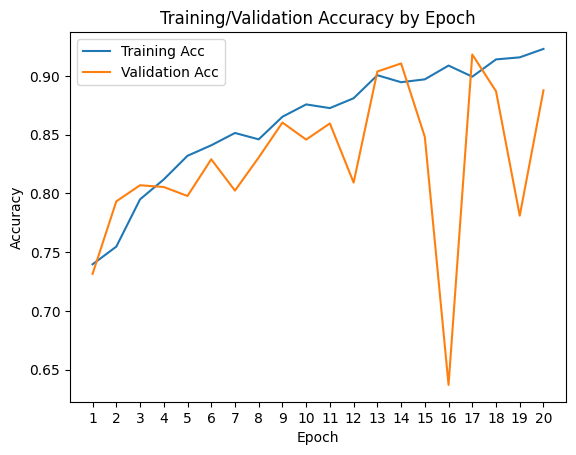

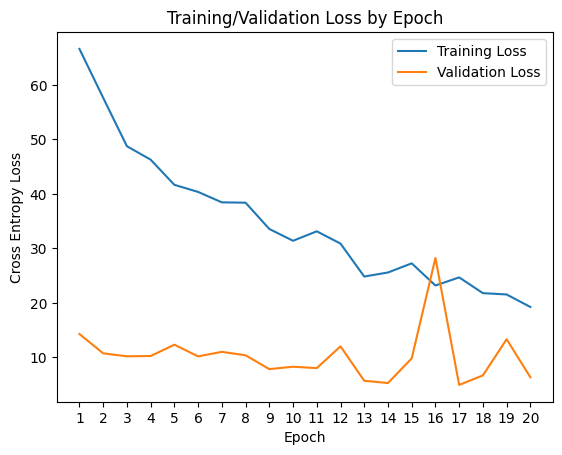

In [35]:
#Training plots
epochs = range(1, 21)

plt.plot(epochs, train_accuracies, label = 'Training Acc')
plt.plot(epochs, val_accuracies, label = 'Validation Acc')
plt.title('Training/Validation Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend();
plt.figure();

plt.plot(epochs, train_losses, label = 'Training Loss')
plt.plot(epochs, val_losses, label = 'Validation Loss')
plt.title('Training/Validation Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.xticks(epochs)
plt.legend()

There are signs of the CNN overfitting, especially at epoch 16. The validation loss and accuracy show strong spikes in undesired directions. Implementing early stopping and manipulating the learning rate during training could help.

In [25]:
#Defining a function to get predictions
def get_predictions(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    return np.array(all_labels), np.array(all_predictions)

In [26]:
true_labels, predicted_labels = get_predictions(brainCNN, val_loader)

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

In [32]:
test_dataset.label_dict

{0: 'pituitary', 1: 'notumor', 2: 'meningioma', 3: 'glioma'}

[Text(45.72222222222221, 0.5, 'True Labels')]

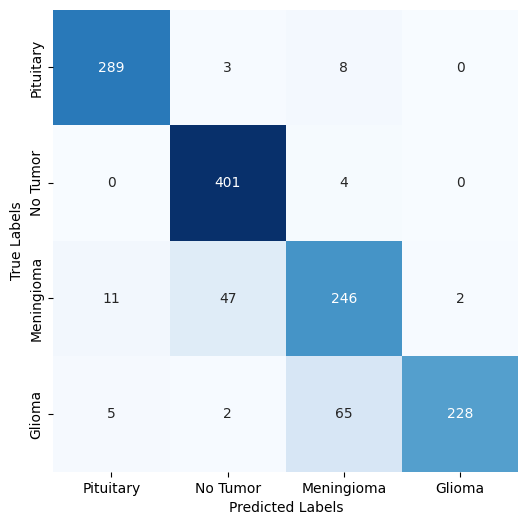

In [31]:
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Pituitary', 'No Tumor', 'Meningioma', "Glioma"], yticklabels=['Pituitary', 'No Tumor', 'Meningioma', "Glioma"])  
hm.set(xlabel='Predicted Labels')
hm.set(ylabel='True Labels')

In [33]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       300
           1       0.89      0.99      0.93       405
           2       0.76      0.80      0.78       306
           3       0.99      0.76      0.86       300

    accuracy                           0.89      1311
   macro avg       0.90      0.88      0.88      1311
weighted avg       0.89      0.89      0.89      1311

